# Lid driven cavity

Napędzane zagłębienie w dwóch wymiarach jest układem, który do dzisiejszego czasu jest przedmiotem badań naukowych. Przykładem może być praca:

http://www.math.sciences.univ-nantes.fr/~saad/cv/computersfluidsoriginalarticle.pdf

Zbadajmy jak zachowuje sie taki układ.

###Wykonaj:

1. Uruchom poniższą symulacje dla parametrów:

     - $nu_{LB}=0.127$: parametr `-visc=0.127`
     - prędkości górnej ścianki $u_{LB}=0.1$
     - rozmiaru siatki układu $N=126$ 
     
2. Oblicz liczbę Reynoldsa dla w/w układu oraz wielkości $\Delta x$ i $\Delta t$ w symulacji siatkowej. Przyjmij, że fizyczny układ ma rozmiar $L=1$ oraz prędkość górnej ścianki $v=1$. Niezbędne wzory są na: http://sailfish.us.edu.pl/simulation_setup.html#mapping-physical-quantities-to-simulation-parameters

3. Czy symulacja osiagęła stan stacjonary? Analizuj dane otrzymane z symulacji za pomocą elementu interaktywnego. Sprawdź precyzyjnie to obliczająć średnią względną  zmianę pola prędkości w jednym kroku symulacji. 

4. Zwiększ liczbę Re do 1000 i 10000 poprzez zmianę lepkośi $\nu_{LB}$. Wykonaj obliczenia, zwiększając liczbę kroków stosownie tak by otrzymac stan bliski stanowi stacjonarnemu.

5. Porównaj otrzymane wyniki z tymi z pracy Bruneau i Saad'a.




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append('./sailfish/')
if not (os.path.isdir('data') or os.path.islink('data')):
    os.mkdir('data')


In [2]:
%%writefile ldc01.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing ldc01.py


In [ ]:
%%sh
rm data/ldc01*npz
export PYTHONPATH=$PWD/sailfish/
python ldc01.py --max_iters=10000 --every=1000 \
 --lat_nx=126 --lat_ny=126 --model=mrt \
 --visc=0.0127\
 --output=data/ldc01 --output_format=npy

In [5]:
!ls data/ldc01* -rtla

-rw-r--r-- 1 marcin marcin    596 Feb 13  2015 data/ldc01.subdomains
-rw-r--r-- 1 marcin marcin 148755 Feb 13  2015 data/ldc01.0.04000.npz
-rw-r--r-- 1 marcin marcin 153208 Feb 13  2015 data/ldc01.0.03000.npz
-rw-r--r-- 1 marcin marcin 151647 Feb 13  2015 data/ldc01.0.02000.npz
-rw-r--r-- 1 marcin marcin 153690 Feb 13  2015 data/ldc01.0.01000.npz
-rw-r--r-- 1 marcin marcin   1286 Feb 13  2015 data/ldc01.0.00000.npz
-rw-r--r-- 1 marcin marcin 149548 Feb 13  2015 data/ldc01.0.10000.npz
-rw-r--r-- 1 marcin marcin 149331 Feb 13  2015 data/ldc01.0.09000.npz
-rw-r--r-- 1 marcin marcin 149149 Feb 13  2015 data/ldc01.0.08000.npz
-rw-r--r-- 1 marcin marcin 150094 Feb 13  2015 data/ldc01.0.07000.npz
-rw-r--r-- 1 marcin marcin 149300 Feb 13  2015 data/ldc01.0.06000.npz
-rw-r--r-- 1 marcin marcin 151506 Feb 13  2015 data/ldc01.0.05000.npz


In [6]:
data = np.load("data/ldc01.0.10000.npz")
data.files

['rho', 'v']

In [7]:
data['v'][0].shape
vx,vy = data['v'] 
ny,nx = vx.shape

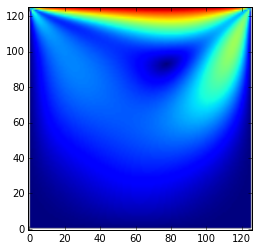

In [8]:
plt.imshow(np.sqrt(vx**2+vy**2),origin='top')

/usr/lib/python2.7/dist-packages/numpy/ma/core.py:778: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


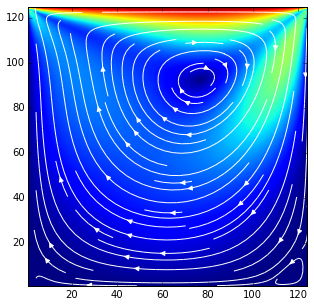

In [9]:
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')


## Analiza czasowej ewolucji przepływu

Możemy łatwo przeanalizować przebieg symulacji z zapisanych pol makroskopowych na dysku. Poniższy kod:
 
 - wczytuje wszystkie pliki pasujące do wzorca `data/ldc01.*.npz`
 - korzystając z elementów interaktywnych w IPython, rysuje pole skalarne wybranej wielkości lub chwilewe linie  prądu w zadanym kroku czasowym
 
`plt.imshow` jest najszybszą metodą wizualizacji pola skalarnego. `plt.streamlines` jest dużo wolniejsze, dlatego dla zapewnienia płynniejszego działania warto mieć kontrolę nad tym co jest rysowane. W przypadku większych pół należy użyć odpowieniego filtrowania za pomocą techniki `slice` by rysowanie jednek klatki nie trwało długo.

In [10]:
%%time 
import glob
frames = []
s = (slice(None),slice(None))
for fn in sorted(glob.glob("data/ldc01.*.npz")):
    data =np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])


CPU times: user 31.6 ms, sys: 3.36 ms, total: 35 ms
Wall time: 308 ms


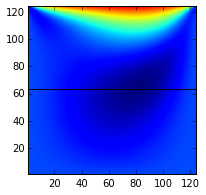

In [11]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=6),\
          sel=widgets.Dropdown(values={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0),\
         stream=widgets.Checkbox())
def g(ith,figsize,sel,stream):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    if stream:
        plt.streamplot(X,Y,vx,vy,color='white',density=1.2)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show()